In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


# Imports

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms import InterpolationMode
import torchvision
from torchvision.models import ViT_B_16_Weights, vit_b_16
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

from tqdm import tqdm

from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


# Config

In [ ]:
config ={
         "dir": "/content/drive/MyDrive/ColabNotebooks/CSE244A/Final/ucsc-cse-244-fall-2023-final-project/train",
         "test_dir": "/content/drive/MyDrive/ColabNotebooks/CSE244A/Final/ucsc-cse-244-fall-2023-final-project/test",
         "saved_model": "/content/drive/MyDrive/ColabNotebooks/CSE244A/Final/ucsc-cse-244-fall-2023-final-project/best_model.pth",
         "random_seed": 0,

         # Transformations
         "target_size": (224, 224),
         "batch_size": 32,
         "tf_mean": [0.485, 0.456, 0.406],
         "tf_std": [0.229, 0.224, 0.225],

         # Mixup
         "use_mixup": True,
         "mixup_alpha": 0.6780631182969984, # controls the strength of the mixup
         "mixup_prob": 0.5,

         # Cutmix
         "cutmix_alpha": 0.6780631182969984,
         "cutmix_prob": 0.5,

         # Train - Val Split
         "train_percent": 0.7,
         "val_size":0.3,

         # Hyper Params
         "lr": 1.3160548406742786e-09, #1e-5
         "eta_min": 7.488100254335479e-05,
         "weight_decay": 7.494067573896596e-05,

         # Early Stop
         "es_patience": 25,

         # ViT_B_16 Layers
         "unfreeze_layers": 5,

         # Added Layers
         # "dropout":0.32698515903181,
         "num_classes": 100,
         "num_epochs": 100,
         }

# Data Prep

In [ ]:
weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
inference_transforms = weights.transforms()


## Train Transforms (with augmentation)

In [ ]:
# image size Train - 384  Optuna - 224
train_transforms = transforms.Compose([
    # Data augmentation transformations
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=None, shear=None),
    # transforms.ColorJitter(brightness=(0.1,0.3), contrast=(0.1,0.3), saturation=(0.1,0.3), hue=(0.1,0.3)),

    # Standard preprocessing for vit_b_16 as per inference_transforms
    transforms.Resize(384, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(mean=config["tf_mean"], std=config["tf_std"]),
])

### Mixup Augmentation

In [ ]:
def mixup_data(x, y, alpha=config["mixup_alpha"], device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

### Cutmix Augmentation

In [ ]:
def cutmix_data(inputs, targets, alpha=config["cutmix_alpha"]):
    # Generate mixed sample
    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size()[0]
    index = torch.randperm(batch_size).to(inputs.device)

    # Randomly choose the cut ratio
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(inputs.size()[2] * cut_rat)
    cut_h = int(inputs.size()[3] * cut_rat)

    # Randomly choose the position of the cut
    cx = np.random.randint(inputs.size()[2])
    cy = np.random.randint(inputs.size()[3])

    bbx1 = np.clip(cx - cut_w // 2, 0, inputs.size()[2])
    bby1 = np.clip(cy - cut_h // 2, 0, inputs.size()[3])
    bbx2 = np.clip(cx + cut_w // 2, 0, inputs.size()[2])
    bby2 = np.clip(cy + cut_h // 2, 0, inputs.size()[3])

    # Perform the cutmix
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[index, :, bbx1:bbx2, bby1:bby2]
    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))

    # The labels are mixed according to the same lambda ratio
    targets_a, targets_b = targets, targets[index]
    return inputs, targets_a, targets_b, lam


## Val Transforms (no augmentation)

In [ ]:
# image size Train - 384  Optuna - 224
val_transforms = transforms.Compose([
    transforms.Resize(384, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(mean=config["tf_mean"], std=config["tf_std"]),
])


## Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, indices=None):
        self.transform = transform
        self.subdirectories = sorted(os.listdir(root_dir), key=lambda x: int(x))
        self.class_to_idx = {self.subdirectories[i]: i for i in range(len(self.subdirectories))}
        self.samples = []

        for subdir in self.subdirectories:
            subdir_path = os.path.join(root_dir, subdir)
            for img_name in os.listdir(subdir_path):
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(subdir_path, img_name)
                    label = self.class_to_idx[subdir]
                    self.samples.append((img_path, label))

        if indices is not None:
            self.samples = [self.samples[i] for i in indices]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


## Train Val Split

In [ ]:
# Directory containing the dataset
dataset_dir = config["dir"]

# Create an instance of the CustomDataset to get all samples
all_dataset = CustomDataset(root_dir=dataset_dir)

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(
    range(len(all_dataset)),
    test_size=config["val_size"],
    random_state=config["random_seed"],
    stratify=[label for _, label in all_dataset.samples])

# Create training and validation datasets using subsets of indices
train_dataset = CustomDataset(root_dir=dataset_dir, transform=train_transforms, indices=train_indices)
val_dataset = CustomDataset(root_dir=dataset_dir, transform=val_transforms, indices=val_indices)

## DataLoaders

In [ ]:
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

### Num of Images for Train - Val

In [ ]:
# Calculate the number of images in the train_loader
num_train_images = len(train_loader.dataset)
print("Number of images in the training dataset:", num_train_images)

# Calculate the number of images in the val_loader
num_val_images = len(val_loader.dataset)
print("Number of images in the validation dataset:", num_val_images)

Number of images in the training dataset: 755
Number of images in the validation dataset: 324


# Show Images

In [ ]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
import matplotlib.pyplot as plt

def show_images(data_loader, class_names, num_images=5):
    # Get a single batch from the data loader
    images, labels = next(iter(data_loader))

    # We will plot `num_images` images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    for i in range(num_images):
        # Undo the normalization and transpose to get the image in HWC format
        img = unnormalize(images[i].clone(), config["tf_mean"], config["tf_std"])
        img = img.permute(1, 2, 0).numpy()

        # Plotting
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_names[labels[i]])

    plt.show()

## Train set

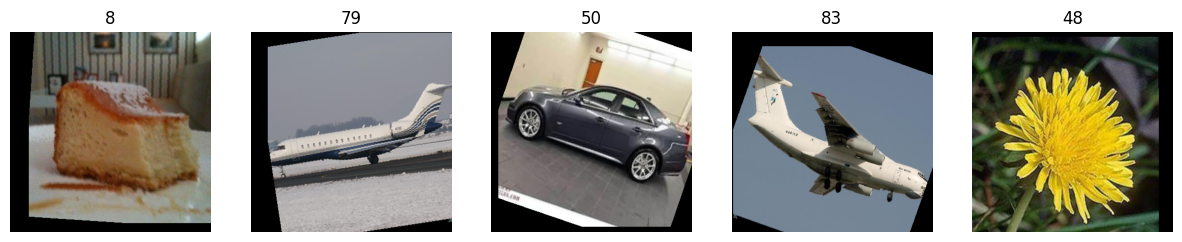

In [ ]:
class_names = [i for i in range(0, 100)]
show_images(train_loader, class_names, num_images=5)

## Val set

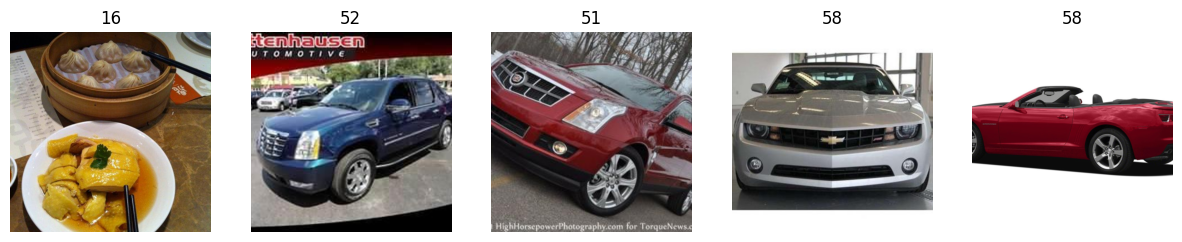

In [ ]:
show_images(val_loader, class_names, num_images=5)

# Model

## Load Model

In [ ]:
weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
model = vit_b_16(weights=weights)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:09<00:00, 36.1MB/s]


## Added Layers

In [ ]:
model.heads[0] = torch.nn.Linear(in_features=model.heads[0].in_features, out_features=config["num_classes"])

## Unfreeze Layeyrs from vit_b_16

In [ ]:
# # Unfreeze the last N layers
# N = config["unfreeze_layers"]
# for layer in model.encoder.layers[-N:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# Training Setup

## Calc Class Weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert labels to integers if they are tensors
all_labels = [label.item() for _, label in train_dataset]

# Ensure that all unique labels are correctly identified
unique_classes = np.unique(all_labels)

# Calculate class weights
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

## Optimizer, Loss Func, LR Scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=config["num_epochs"]/2, eta_min=config["eta_min"])
scaler = GradScaler()

# Move the model to GPU if available
model = model.to(device)

# Training

## Training Func

In [ ]:
def train_one_epoch(epoch_index, scaler, train_loader, model, loss_func, optimizer, device, config):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    model.train()
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch_index}"):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        with autocast():
            # Randomly decide whether to use Mixup or CutMix
            if np.random.rand() < config["mixup_prob"]:
                # Apply Mixup
                inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=config["mixup_alpha"], device=device)
            elif np.random.rand() < config["cutmix_prob"]:
                # Apply CutMix
                inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=config["cutmix_alpha"])
            else:
                # No augmentation
                lam, targets_a, targets_b = 1, targets, targets

            outputs = model(inputs)
            if lam < 1:
                loss = lam * loss_func(outputs, targets_a) + (1 - lam) * loss_func(outputs, targets_b)
            else:
                loss = loss_func(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            if lam < 1:
                correct_predictions += ((predicted == targets_a) | (predicted == targets_b)).sum().item()
            else:
                correct_predictions += (predicted == targets).sum().item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        total_predictions += targets.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    return train_loss, train_accuracy

## Val Func

In [ ]:
def validate(model, val_loader, loss_func, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validating"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct_predictions / total_predictions
    return val_loss, val_accuracy

## Training Loop

In [ ]:
# Initialize lists to hold the metrics
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []


model_save_path = config["saved_model"]
if os.path.isfile(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=torch.device("cpu")))
    print("Model loaded from", model_save_path)
else:
    print("Saved model not found. Starting from scratch.")


best_val_loss = float("inf")
patience_counter = 0
early_stopping_patience = config["es_patience"]

for epoch in range(config["num_epochs"]):
    train_loss, train_accuracy = train_one_epoch(epoch, scaler, train_loader, model, loss_func, optimizer, device, config)
    val_loss, val_accuracy = validate(model, val_loader, loss_func, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch}: Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    print(f"Epoch {epoch}: Val Loss: {val_loss}, Val Accuracy: {val_accuracy}\n")

    # Print Learning Rate
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}\n")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss

        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved: Improved validation loss at epoch {epoch}\nBest validation: {best_val_loss}\n")

        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    # Update the learning rate
    lr_scheduler.step()

Saved model not found. Starting from scratch.


Validating: 100%|██████████| 11/11 [02:03<00:00, 11.21s/it]


Epoch 0: Train Loss: 4.932995359102885, Train Accuracy: 0.015894039735099338
Epoch 0: Val Loss: 5.012246478687633, Val Accuracy: 0.006172839506172839

Current Learning Rate: 1.3160548406742786e-09

Model saved: Improved validation loss at epoch 0
Best validation: 5.012246478687633



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 1: Train Loss: 4.934033393859863, Train Accuracy: 0.013245033112582781
Epoch 1: Val Loss: 5.001000361009077, Val Accuracy: 0.009259259259259259

Current Learning Rate: 7.519503316454697e-08

Model saved: Improved validation loss at epoch 1
Best validation: 5.001000361009077



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 2: Train Loss: 4.9411550760269165, Train Accuracy: 0.01456953642384106
Epoch 2: Val Loss: 4.956426663832231, Val Accuracy: 0.009259259259259259

Current Learning Rate: 2.9654040156077896e-07

Model saved: Improved validation loss at epoch 2
Best validation: 4.956426663832231



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 3: Train Loss: 4.842830260594686, Train Accuracy: 0.017218543046357615
Epoch 3: Val Loss: 4.855176015333696, Val Accuracy: 0.009259259259259259

Current Learning Rate: 6.644786109834115e-07

Model saved: Improved validation loss at epoch 3
Best validation: 4.855176015333696



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 4: Train Loss: 4.74194594224294, Train Accuracy: 0.018543046357615896
Epoch 4: Val Loss: 4.694698073647239, Val Accuracy: 0.012345679012345678

Current Learning Rate: 1.1775575774148277e-06

Model saved: Improved validation loss at epoch 4
Best validation: 4.694698073647239



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 5: Train Loss: 4.574578622976939, Train Accuracy: 0.052980132450331126
Epoch 5: Val Loss: 4.462202527306297, Val Accuracy: 0.033950617283950615

Current Learning Rate: 1.833752412577983e-06

Model saved: Improved validation loss at epoch 5
Best validation: 4.462202527306297



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 6: Train Loss: 4.304818004369736, Train Accuracy: 0.10463576158940398
Epoch 6: Val Loss: 4.149525924162432, Val Accuracy: 0.08333333333333333

Current Learning Rate: 2.6304734152454213e-06

Model saved: Improved validation loss at epoch 6
Best validation: 4.149525924162432



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 7: Train Loss: 3.9419297873973846, Train Accuracy: 0.17350993377483442
Epoch 7: Val Loss: 3.651150703430176, Val Accuracy: 0.1882716049382716

Current Learning Rate: 3.564576291606797e-06

Model saved: Improved validation loss at epoch 7
Best validation: 3.651150703430176



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 8: Train Loss: 3.280904104312261, Train Accuracy: 0.3576158940397351
Epoch 8: Val Loss: 3.0724120140075684, Val Accuracy: 0.3487654320987654

Current Learning Rate: 4.632374564360152e-06

Model saved: Improved validation loss at epoch 8
Best validation: 3.0724120140075684



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 9: Train Loss: 2.903886546691259, Train Accuracy: 0.5099337748344371
Epoch 9: Val Loss: 2.5632054805755615, Val Accuracy: 0.44135802469135804

Current Learning Rate: 5.829654121553528e-06

Model saved: Improved validation loss at epoch 9
Best validation: 2.5632054805755615



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 10: Train Loss: 2.6240082532167435, Train Accuracy: 0.6172185430463576
Epoch 10: Val Loss: 2.2293575568632646, Val Accuracy: 0.49691358024691357

Current Learning Rate: 7.151689847759699e-06

Model saved: Improved validation loss at epoch 10
Best validation: 2.2293575568632646



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 11: Train Loss: 2.207266283531984, Train Accuracy: 0.7298013245033113
Epoch 11: Val Loss: 1.9523600123145364, Val Accuracy: 0.5617283950617284

Current Learning Rate: 8.593264271947998e-06

Model saved: Improved validation loss at epoch 11
Best validation: 1.9523600123145364



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 12: Train Loss: 1.9952207207679749, Train Accuracy: 0.7814569536423841
Epoch 12: Val Loss: 1.7343876036730679, Val Accuracy: 0.6234567901234568

Current Learning Rate: 1.0148688158458858e-05

Model saved: Improved validation loss at epoch 12
Best validation: 1.7343876036730679



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 13: Train Loss: 1.4679003755251567, Train Accuracy: 0.866225165562914
Epoch 13: Val Loss: 1.5069374713030728, Val Accuracy: 0.6388888888888888

Current Learning Rate: 1.1811822959817791e-05

Model saved: Improved validation loss at epoch 13
Best validation: 1.5069374713030728



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 14: Train Loss: 1.3281502723693848, Train Accuracy: 0.9245033112582781
Epoch 14: Val Loss: 1.4214361960237676, Val Accuracy: 0.6666666666666666

Current Learning Rate: 1.3576105042777868e-05

Model saved: Improved validation loss at epoch 14
Best validation: 1.4214361960237676



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 15: Train Loss: 1.322345823670427, Train Accuracy: 0.9112582781456954
Epoch 15: Val Loss: 1.416128391569311, Val Accuracy: 0.6820987654320988

Current Learning Rate: 1.5434571591981437e-05

Model saved: Improved validation loss at epoch 15
Best validation: 1.416128391569311



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 16: Train Loss: 1.3028297293931246, Train Accuracy: 0.9337748344370861
Epoch 16: Val Loss: 1.349200503392653, Val Accuracy: 0.6851851851851852

Current Learning Rate: 1.7379888089011433e-05

Model saved: Improved validation loss at epoch 16
Best validation: 1.349200503392653



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 17: Train Loss: 1.4192128175248702, Train Accuracy: 0.9311258278145695
Epoch 17: Val Loss: 1.2294311225414276, Val Accuracy: 0.7067901234567902

Current Learning Rate: 1.9404377258384606e-05

Model saved: Improved validation loss at epoch 17
Best validation: 1.2294311225414276



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 18: Train Loss: 1.005791508903106, Train Accuracy: 0.9390728476821192
Epoch 18: Val Loss: 1.2115585262125188, Val Accuracy: 0.7037037037037037

Current Learning Rate: 2.1500049366250583e-05

Model saved: Improved validation loss at epoch 18
Best validation: 1.2115585262125188



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 19: Train Loss: 1.0635518577570717, Train Accuracy: 0.9642384105960264
Epoch 19: Val Loss: 1.1683274724266746, Val Accuracy: 0.7407407407407407

Current Learning Rate: 2.365863375222113e-05

Model saved: Improved validation loss at epoch 19
Best validation: 1.1683274724266746



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 20: Train Loss: 1.17172789418449, Train Accuracy: 0.937748344370861
Epoch 20: Val Loss: 1.1789368418130008, Val Accuracy: 0.6975308641975309

Current Learning Rate: 2.587161146988823e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 21: Train Loss: 1.1431379265462358, Train Accuracy: 0.9403973509933775
Epoch 21: Val Loss: 1.1549440622329712, Val Accuracy: 0.7067901234567902

Current Learning Rate: 2.813024890721359e-05

Model saved: Improved validation loss at epoch 21
Best validation: 1.1549440622329712



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 22: Train Loss: 1.1154722180217505, Train Accuracy: 0.9721854304635762
Epoch 22: Val Loss: 1.1783439110625873, Val Accuracy: 0.6975308641975309

Current Learning Rate: 3.0425632254105368e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 23: Train Loss: 1.4292973959818482, Train Accuracy: 0.9086092715231788
Epoch 23: Val Loss: 1.236917105588046, Val Accuracy: 0.6882716049382716

Current Learning Rate: 3.2748702681154303e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 24: Train Loss: 1.0042855041101575, Train Accuracy: 0.9708609271523179
Epoch 24: Val Loss: 1.1850421130657196, Val Accuracy: 0.6697530864197531

Current Learning Rate: 3.509029209069476e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 25: Train Loss: 1.1258126224080722, Train Accuracy: 0.9496688741721855
Epoch 25: Val Loss: 1.123835265636444, Val Accuracy: 0.7037037037037037

Current Learning Rate: 3.744115929909772e-05

Model saved: Improved validation loss at epoch 25
Best validation: 1.123835265636444



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 26: Train Loss: 0.7158464152986804, Train Accuracy: 0.9841059602649007
Epoch 26: Val Loss: 1.1463420228524641, Val Accuracy: 0.7006172839506173

Current Learning Rate: 3.979202650750067e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 27: Train Loss: 0.9629370591137558, Train Accuracy: 0.9695364238410596
Epoch 27: Val Loss: 1.244047928940166, Val Accuracy: 0.6882716049382716

Current Learning Rate: 4.213361591704112e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 28: Train Loss: 1.1081414578172069, Train Accuracy: 0.9483443708609272
Epoch 28: Val Loss: 1.1203305341980674, Val Accuracy: 0.7129629629629629

Current Learning Rate: 4.4456686344090065e-05

Model saved: Improved validation loss at epoch 28
Best validation: 1.1203305341980674



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 29: Train Loss: 1.10347892002513, Train Accuracy: 0.9403973509933775
Epoch 29: Val Loss: 1.273001026023518, Val Accuracy: 0.6759259259259259

Current Learning Rate: 4.6752069690981856e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 30: Train Loss: 1.0909002204425633, Train Accuracy: 0.9390728476821192
Epoch 30: Val Loss: 1.1897136027162725, Val Accuracy: 0.6604938271604939

Current Learning Rate: 4.9010707128307196e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 31: Train Loss: 1.1685159901777904, Train Accuracy: 0.9311258278145695
Epoch 31: Val Loss: 1.2239335612817244, Val Accuracy: 0.6635802469135802

Current Learning Rate: 5.122368484597429e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 32: Train Loss: 0.662582075688988, Train Accuracy: 0.9801324503311258
Epoch 32: Val Loss: 1.1050545004281132, Val Accuracy: 0.6975308641975309

Current Learning Rate: 5.3382269231944855e-05

Model saved: Improved validation loss at epoch 32
Best validation: 1.1050545004281132



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 33: Train Loss: 1.0906150831530492, Train Accuracy: 0.9509933774834437
Epoch 33: Val Loss: 1.2472207681699232, Val Accuracy: 0.6697530864197531

Current Learning Rate: 5.547794133981084e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 34: Train Loss: 0.6065048939393213, Train Accuracy: 0.9721854304635762
Epoch 34: Val Loss: 1.189389618960294, Val Accuracy: 0.6820987654320988

Current Learning Rate: 5.7502430509184026e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 35: Train Loss: 1.0686990243072312, Train Accuracy: 0.952317880794702
Epoch 35: Val Loss: 1.2266377969221636, Val Accuracy: 0.6944444444444444

Current Learning Rate: 5.9447747006213995e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 36: Train Loss: 0.7898812928857902, Train Accuracy: 0.9695364238410596
Epoch 36: Val Loss: 1.1094623885371468, Val Accuracy: 0.6944444444444444

Current Learning Rate: 6.130621355541758e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 37: Train Loss: 0.8673563885192076, Train Accuracy: 0.9668874172185431
Epoch 37: Val Loss: 1.1881101429462433, Val Accuracy: 0.6851851851851852

Current Learning Rate: 6.307049563837766e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 38: Train Loss: 0.8062027380801737, Train Accuracy: 0.9682119205298013
Epoch 38: Val Loss: 1.2131912328980186, Val Accuracy: 0.6975308641975309

Current Learning Rate: 6.47336304397366e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 39: Train Loss: 0.9034587921729932, Train Accuracy: 0.9549668874172186
Epoch 39: Val Loss: 1.2901537729935213, Val Accuracy: 0.6481481481481481

Current Learning Rate: 6.628905432624745e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 40: Train Loss: 1.0894573924597353, Train Accuracy: 0.9509933774834437
Epoch 40: Val Loss: 1.3196180625395342, Val Accuracy: 0.6666666666666666

Current Learning Rate: 6.773062875043575e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 41: Train Loss: 0.8126495327645292, Train Accuracy: 0.9708609271523179
Epoch 41: Val Loss: 1.3802598389712246, Val Accuracy: 0.6450617283950617

Current Learning Rate: 6.905266447664191e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 42: Train Loss: 1.0382232556585222, Train Accuracy: 0.9629139072847682
Epoch 42: Val Loss: 1.290648725899783, Val Accuracy: 0.6327160493827161

Current Learning Rate: 7.02499440338353e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 43: Train Loss: 1.0735758425047, Train Accuracy: 0.9390728476821192
Epoch 43: Val Loss: 1.235336196693507, Val Accuracy: 0.6574074074074074

Current Learning Rate: 7.131774230658864e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 44: Train Loss: 1.0982494681763153, Train Accuracy: 0.9483443708609272
Epoch 44: Val Loss: 1.2370491217483173, Val Accuracy: 0.6635802469135802

Current Learning Rate: 7.225184518295003e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 45: Train Loss: 1.0145938630836706, Train Accuracy: 0.9589403973509933
Epoch 45: Val Loss: 1.1821865899996324, Val Accuracy: 0.7037037037037037

Current Learning Rate: 7.304856618561747e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 46: Train Loss: 0.8544713618854681, Train Accuracy: 0.9576158940397351
Epoch 46: Val Loss: 1.3696208758787676, Val Accuracy: 0.6666666666666666

Current Learning Rate: 7.370476102078064e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 47: Train Loss: 1.2549665218684822, Train Accuracy: 0.9245033112582781
Epoch 47: Val Loss: 1.3862900246273389, Val Accuracy: 0.6049382716049383

Current Learning Rate: 7.421783998721205e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 48: Train Loss: 0.8604017549660057, Train Accuracy: 0.9668874172185431
Epoch 48: Val Loss: 1.2593503377654336, Val Accuracy: 0.7006172839506173

Current Learning Rate: 7.458577819663469e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 49: Train Loss: 1.081400461960584, Train Accuracy: 0.9562913907284768
Epoch 49: Val Loss: 1.4185451648452065, Val Accuracy: 0.6388888888888888

Current Learning Rate: 7.480712356503092e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 50: Train Loss: 0.8059121345480283, Train Accuracy: 0.976158940397351
Epoch 50: Val Loss: 1.234161458232186, Val Accuracy: 0.6728395061728395

Current Learning Rate: 7.488100254335479e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 51: Train Loss: 0.8199324214365333, Train Accuracy: 0.9748344370860927
Epoch 51: Val Loss: 1.1960447213866494, Val Accuracy: 0.6820987654320988

Current Learning Rate: 7.480712356503092e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 52: Train Loss: 0.7880465428655347, Train Accuracy: 0.9629139072847682
Epoch 52: Val Loss: 1.2352583272890612, Val Accuracy: 0.6697530864197531

Current Learning Rate: 7.458577819663467e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 53: Train Loss: 0.728637955423134, Train Accuracy: 0.9774834437086093
Epoch 53: Val Loss: 1.3080437020822004, Val Accuracy: 0.6481481481481481

Current Learning Rate: 7.421783998721201e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Epoch 54: Train Loss: 0.7226544667889053, Train Accuracy: 0.9788079470198675
Epoch 54: Val Loss: 1.2884295366027139, Val Accuracy: 0.6790123456790124

Current Learning Rate: 7.370476102078057e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Epoch 55: Train Loss: 0.8592227620538324, Train Accuracy: 0.9735099337748344
Epoch 55: Val Loss: 1.375603903423656, Val Accuracy: 0.6604938271604939

Current Learning Rate: 7.304856618561736e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Epoch 56: Train Loss: 0.8607218438992277, Train Accuracy: 0.976158940397351
Epoch 56: Val Loss: 1.1937439929355274, Val Accuracy: 0.6820987654320988

Current Learning Rate: 7.225184518294987e-05



Validating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]

Epoch 57: Train Loss: 0.5809482036468884, Train Accuracy: 0.9814569536423841
Epoch 57: Val Loss: 1.1930855512619019, Val Accuracy: 0.6851851851851852

Current Learning Rate: 7.131774230658843e-05

Early stopping triggered


## Plots

### Loss

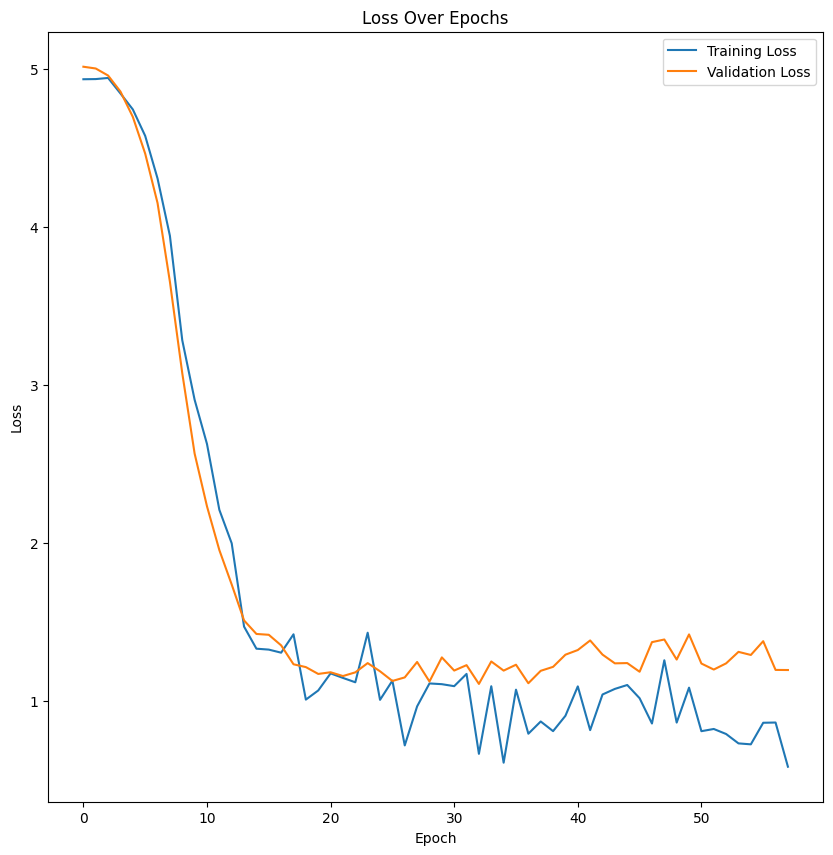

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Accuracy

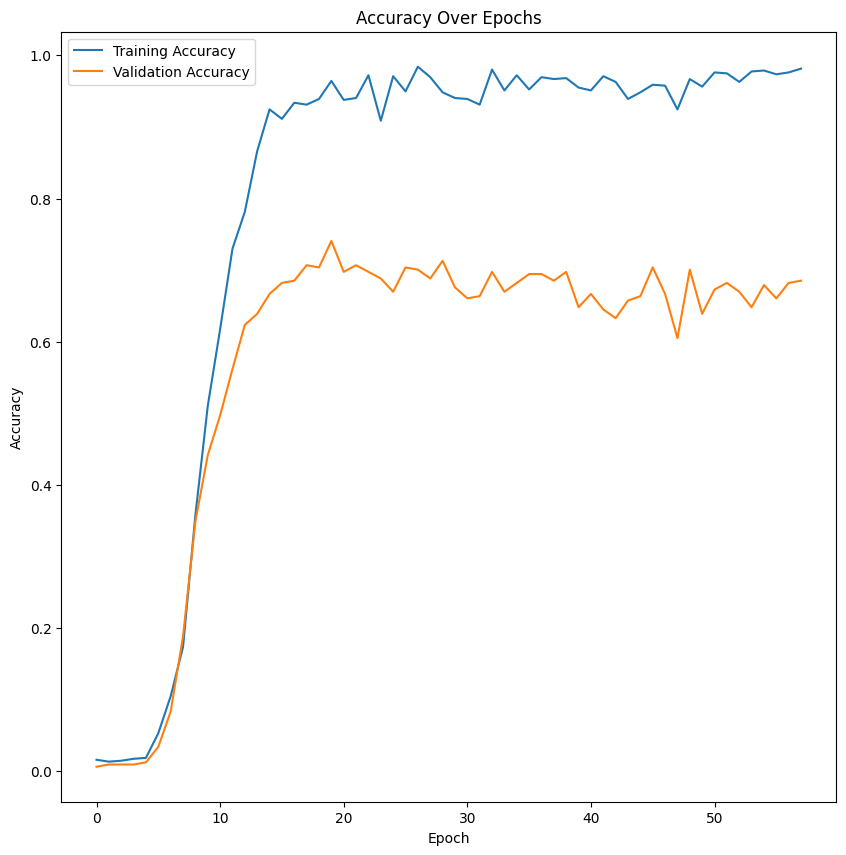

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Test

## Load Test Set

In [ ]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Custom dataset for testing
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted(os.listdir(root_dir), key=lambda x: int(os.path.splitext(x)[0]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Set up the same transformations as validation dataset
test_transforms = val_transforms

# Create the test dataset and loader
test_dir = config["test_dir"]
test_dataset = TestDataset(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# Load the best model
model_save_path = config["saved_model"]
if os.path.isfile(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Best model loaded from", model_save_path)
else:
    raise FileNotFoundError("Saved model not found!")

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    predictions = []
    img_names = []
    for inputs, names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        img_names.extend(names)

# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    "ID": img_names,
    "Label": predictions
})

# Extract the numeric part for sorting
submission_df["ID"] = submission_df["ID"].str.replace(".jpg", "", regex=False).astype(int)
submission_df.sort_values("ID", inplace=True)

# Add the "".jpg" extension back if required for the submission format
submission_df["ID"] = submission_df["ID"].astype(str) + ".jpg"

# Save the predictions to a new CSV file
submission_file = "/content/drive/MyDrive/ColabNotebooks/CSE244A/Final/ucsc-cse-244-fall-2023-final-project/submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Submission CSV is ready and saved to '{submission_file}'")

Best model loaded from /content/drive/MyDrive/ColabNotebooks/CSE244A/Final/ucsc-cse-244-fall-2023-final-project/best_model.pth
Submission CSV is ready and saved to '/content/drive/MyDrive/ColabNotebooks/CSE244A/Final/ucsc-cse-244-fall-2023-final-project/submission.csv'


In [ ]:
torch.save(model.state_dict(), "model_weights.pth")